## L1000FWD Predicted Side Effects Drug-Set Library
### Drug-set labels: Predicted Side Effects
#### ALL DATABASES ACCESSED 09/2019
##### Author : Eryk Kropiwnicki | eryk.kropiwnicki@icahn.mssm.edu

In [1]:
import json
import pandas as pd
import requests
import time
from collections import defaultdict
import csv
import os
import matplotlib

In [2]:
os.chdir('../../scripts')
from export_script import *
os.chdir('../notebooks/L1000FWD')

In [3]:
df = pd.read_csv('input/pert_id_inchi.tsv', delimiter = '\t')
df.head()

,pert_id,inchi_key
0,BRD-A00546892,YSXKPIUOCJLQIE-UHFFFAOYSA-N
1,BRD-A00993607,PAZJSJFMUHDSTF-UHFFFAOYSA-N
2,BRD-A01320529,GIIZNNXWQWCKIB-UHFFFAOYSA-N
3,BRD-A01787639,HRRBJVNMSRJFHQ-UHFFFAOYSA-N
4,BRD-A01826957,DSFGXPJYDCSWTA-UHFFFAOYSA-N


In [4]:
pert_ids = df['pert_id'].tolist()
pert_id_inchi= df.set_index('pert_id').to_dict()['inchi_key']

In [5]:
len(pert_ids)

4901

In [ ]:
# Matching signatures to predicted side effects using SEP-L1000 API #
failed_list = []
output = []

for pert_id in pert_ids:
    side_effect_list = []
    try:
        url = 'http://maayanlab.net/SEP-L1000/get_drug_se.php?pert_id='+pert_id
        response = requests.get(url)
    except ValueError:
        pass
    try:
        for item in response.json():
            side_effect_list.append(item)

        # replace pert_id with InChiKey and associate with side effects
        output.append({pert_id_inchi[pert_id]:side_effect_list})
    except:
        failed_list.append(pert_id)
    time.sleep(0.5)
    
with open('input/predicted_side_effects.json', 'w') as f:
    json.dump(output,f, indent = 4)
f.close()

In [6]:
with open('input/predicted_side_effects.json','r') as f:
    se_data = json.load(f)

In [7]:
se_list = []
inchi_list = []
probs = []
for dictionary in se_data:
    for inchi_key,lists in dictionary.items():
        for se in lists:
            if float(se['p_val']) > 0.5:
                probs.append(float(se['p_val']))
                se_list.append(se['name'])
                inchi_list.append(inchi_key)
                
df = pd.DataFrame()
df['inchi_key'] = inchi_list
df['side_effect'] = se_list
df['probability'] = probs

In [8]:
df.head()

,inchi_key,side_effect,probability
0,YSXKPIUOCJLQIE-UHFFFAOYSA-N,Dry mouth,0.86
1,YSXKPIUOCJLQIE-UHFFFAOYSA-N,Urinary retention,0.78
2,YSXKPIUOCJLQIE-UHFFFAOYSA-N,Epigastric discomfort,0.61
3,YSXKPIUOCJLQIE-UHFFFAOYSA-N,Bradycardia,0.81
4,YSXKPIUOCJLQIE-UHFFFAOYSA-N,Disorientation,0.72


In [9]:
# Filter each side effect by top 1000 associations by probability
df_filtered = df.sort_values(by = ['side_effect', 'probability'], ascending = False)\
    .groupby('side_effect')\
    .head(1000)

In [10]:
# Find cutoff for 1000th term to create cutoff list for each side effect
df_cutoff = df_filtered.groupby('side_effect')\
    .tail(1)

In [11]:
cutoff_dict = df_cutoff.set_index('side_effect').to_dict()['probability']

In [12]:
for index,row in df.iterrows():
    side_effect = row['side_effect']
    cutoff = cutoff_dict[side_effect]
    if row['probability'] < cutoff:
        df.drop(index, inplace = True)

In [13]:
id_list = (zip(df['side_effect'].tolist(),df['inchi_key'].tolist()))
drugsetlibrary = defaultdict(list)
for k,v in id_list:
    drugsetlibrary[k].append(v)
drugsetlibrary = {k:list(set(v)) for k,v in drugsetlibrary.items() if len(set(v))>=5}

### Histogram of drugset size distribution

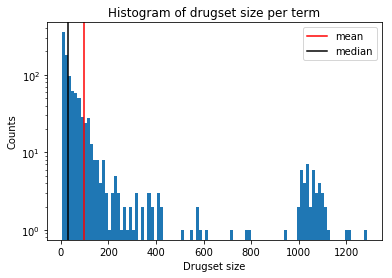

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import figure, text, scatter, show

df_setsize = pd.DataFrame(columns = ['Side_effect','Drugset_size'])
se = []
drugset = []
for k,v in drugsetlibrary.items():
    se.append(k)
    drugset.append(len(set(v)))
df_setsize['Side_effect'] = se
df_setsize['Drugset_size'] = drugset

plt.figure()
plt.hist(df_setsize['Drugset_size'].values, bins=100)
plt.xlabel('Drugset size')
plt.ylabel('Counts')
plt.title('Histogram of drugset size per term')
plt.yscale('log')
plt.axvline(np.mean(df_setsize['Drugset_size']), color='red', label='mean')
plt.axvline(np.median(df_setsize['Drugset_size']), color='black', label='median')
plt.legend()
plt.show()

### Library counts

In [15]:
library_counts(drugsetlibrary)

4852 unique drugs
1013 unique association terms
100635 unique associations
99.34353405725568 average drugs per term


### Exporting the drug-set library in GMT format

In [16]:
os.chdir('../../data/L1000FWD')

In [17]:
gmt_formatter(drugsetlibrary, 'L1000FWD_predicted_side_effects.gmt')